# This notebook studies how new sets of labels appear in time and how frequently they'll reappear in the future

### Import dataset

In [1]:
from tqdm import tqdm
tqdm.pandas()
import pandas as pd 
predicted_corpus = pd.read_parquet(f"../1.Dataset/Inference_with_predictions/logprecis_predictions.parquet")
predicted_corpus.head(2)

,session_id,sequence_words,sequence_predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D..."


Concatenate `sequence words` and `sequence_predictions`

In [2]:
predicted_corpus["sessions"] = predicted_corpus["sequence_words"].progress_apply(
                                                lambda split_session: " ".join(split_session))
predicted_corpus["predictions"] = predicted_corpus["sequence_predictions"].progress_apply(
                                                lambda split_prediction: " -- ".join(split_prediction))
print(f"Corpus contains {predicted_corpus.shape[0]:,} sessions ({predicted_corpus.sessions.nunique():,} unique)")
print(f"Furthermore, corpus contains {predicted_corpus.predictions.nunique()} unique fingerprints")
predicted_corpus.head(2)

100%|██████████| 233035/233035 [00:01<00:00, 147107.70it/s]


Corpus contains 233,035 sessions (233,035 unique)
Furthermore, corpus contains 1673 unique fingerprints


,session_id,sequence_words,sequence_predictions,sessions,predictions
0,0,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,"[enable, ;, system, ;, shell, ;, sh, ;, cat, /...","[Discovery, Discovery, Discovery, Discovery, D...",enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


#### Filter "/system scheduler" sessions --> not bash

In [3]:
print(f"Before filtering '/system scheduler' sessions: {predicted_corpus.shape[0]}")
predicted_corpus = predicted_corpus[~predicted_corpus.sessions.str.contains("/system scheduler")]
print(f"After filtering '/system scheduler' sessions: {predicted_corpus.shape[0]}")

Before filtering '/system scheduler' sessions: 233035


After filtering '/system scheduler' sessions: 232836


Load original data

In [4]:
full_corpus = pd.read_csv(f"../1.Dataset/Inference/cyberlab_data.csv")
if "session_id" in full_corpus.columns:
    full_corpus = full_corpus.drop("session_id", axis=1)
full_corpus = full_corpus.reset_index().rename({"index":"session_id"}, axis=1)
full_corpus.head(2)

,session_id,session,sensor,first_timestamp,date
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,2019-06-04
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,2019-06-04


Join with predictions

In [5]:
joined_corpus = full_corpus[["session_id", "first_timestamp", "sensor", "date"]].merge(predicted_corpus[["session_id", "sessions", "predictions"]], on="session_id")
joined_corpus.head(2)

,session_id,first_timestamp,sensor,date,sessions,predictions
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


#### Create date attribute

In [6]:
joined_corpus["first_timestamp"] = pd.to_datetime(joined_corpus["first_timestamp"])
joined_corpus["date"] = joined_corpus["first_timestamp"].apply(lambda datetime: datetime.date())
joined_corpus.head(2)

,session_id,first_timestamp,sensor,date,sessions,predictions
0,0,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...
1,1,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,enable ; system ; shell ; sh ; cat /proc/mount...,Discovery -- Discovery -- Discovery -- Discove...


#### Obtain percentage of Tactics before and after the server update

In [7]:
from datetime import datetime
DATE_UPDATE_SERVER = "08/11/2019" #According to https://zenodo.org/records/3687527#.YmEr9pJBxQL
server_update_date = datetime.strptime(DATE_UPDATE_SERVER, '%d/%m/%Y').date()
server_update_datetime = datetime.strptime(DATE_UPDATE_SERVER, '%d/%m/%Y')
print(f"Server update occurred in {server_update_date}")

Server update occurred in 2019-11-08


In [8]:
sessions_date_predictions = joined_corpus[["sessions", "predictions", "date"]].copy()
sessions_date_predictions["splitted_session"] = sessions_date_predictions["sessions"].apply(lambda session: session.split(" "))
sessions_date_predictions["splitted_prediction"] = sessions_date_predictions["predictions"].apply(lambda predictions: predictions.split(" -- "))
exploded_df = sessions_date_predictions[["splitted_session", "splitted_prediction", "date"]].explode(["splitted_session", "splitted_prediction"])
print(f"Exploded dataset contains {exploded_df.shape[0]} rows and {exploded_df.shape[1]} columns")
exploded_df.head(2)

Exploded dataset contains 28148367 rows and 3 columns


,splitted_session,splitted_prediction,date
0,enable,Discovery,2019-06-04
0,;,Discovery,2019-06-04


How many commands before? How many after?

In [9]:
after_update = exploded_df[exploded_df.date >= server_update_date]
before_update = exploded_df[exploded_df.date < server_update_date]
print(f"{after_update.shape[0]:,} words after; {before_update.shape[0]:,} words before")

17,188,576 words after; 8,838,455 words before


Stats on the words per class - before and after

In [10]:
stats_before = before_update.groupby("splitted_prediction")["splitted_session"].count().reset_index(name = "words_per_class") 
stats_before["percentage"] = stats_before.words_per_class.apply(lambda el: round(el / before_update.shape[0] * 100, 3))
print("Before:")
stats_before

Before:


,splitted_prediction,words_per_class,percentage
0,Defense Evasion,117553,1.330
1,Discovery,6964350,78.796
2,Execution,1037929,11.743
3,Harmless,1618,0.018
4,Impact,54,0.001
5,Other,3730,0.042
6,Persistence,713221,8.070


In [11]:
stats_after = after_update.groupby("splitted_prediction")["splitted_session"].count().reset_index(name = "words_per_class") 
stats_after["percentage"] = stats_after.words_per_class.apply(lambda el: round(el / after_update.shape[0] * 100, 3))
print("After:")
stats_after

After:


,splitted_prediction,words_per_class,percentage
0,Defense Evasion,20984,0.122
1,Discovery,14110380,82.092
2,Execution,728024,4.236
3,Harmless,6788,0.039
4,Impact,152,0.001
5,Other,37,0.000
6,Persistence,2322211,13.510


#### Visualize them in the time-series of points

Now, for each day, save all predictions made by the model

Basically, each day gets a document assigned. The document contains the concatenation of fingerprints.

In [12]:
predictions_per_day = joined_corpus.groupby("date")["predictions"].agg(list).reset_index().rename({"predictions":"predictions_per_day"}, axis = 1)
predictions_per_day["predictions_per_day"] = predictions_per_day["predictions_per_day"].apply(lambda list_predictions: " __ ".join(list_predictions))
predictions_per_day.head(2)

,date,predictions_per_day
0,2019-06-04,Discovery -- Discovery -- Discovery -- Discove...
1,2019-06-05,Discovery -- Discovery -- Discovery -- Discove...


Now, use count vectorizer. 

Each fingerprint will be a word of the vocabulary

In [13]:
def custom_tokenizer(session):
    return [el.strip() for el in session.split(" __ ")]

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, lowercase = False, binary = True, token_pattern=None)
X = vectorizer.fit_transform(predictions_per_day.predictions_per_day).toarray()
names = vectorizer.get_feature_names_out()
df_count_vectorizer = pd.DataFrame(X, columns=names, index = predictions_per_day.date)
print(f"Dataframe has shape {df_count_vectorizer.shape[0]} (N Days) x {df_count_vectorizer.shape[1]} (N fingerprints)")

Dataframe has shape 233 (N Days) x 1563 (N fingerprints)


Now, for each fingerprint, obtain the first date in which the fingerprint appeared

In [15]:
joined_corpus.sort_values(by = "first_timestamp", inplace = True)
joined_corpus_nan_dropped = joined_corpus.dropna().copy()
first_appearance_per_prediction = joined_corpus_nan_dropped.groupby("predictions")["date"].agg("first").reset_index()
first_appearance_per_prediction.sort_values(by = "date", ascending = True, inplace = True)
first_appearance_per_prediction.head(2)

,predictions,date
1418,Execution -- Execution -- Execution -- Executi...,2019-06-04
49,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04


According to previous notebook, we will now focus only on fingerprints with >10 associated sessions

In [16]:
sessions_x_fingerprint = joined_corpus_nan_dropped.value_counts("predictions").reset_index().rename({0:"associated_sessions"}, axis = 1)
sessions_x_fingerprint.head(2)

,predictions,associated_sessions
0,Discovery -- Discovery -- Discovery -- Discove...,97666
1,Discovery -- Discovery -- Discovery -- Discove...,30644


In [17]:
THRESHOLD = 10
filtered_fingerprints = sessions_x_fingerprint[sessions_x_fingerprint.associated_sessions>THRESHOLD]
filtered_corpus = joined_corpus_nan_dropped[joined_corpus_nan_dropped.predictions.isin(filtered_fingerprints.predictions)].copy()
print(f"{filtered_fingerprints.shape[0]:,} fingerprints ({filtered_fingerprints.shape[0]/sessions_x_fingerprint.shape[0]*100:.2f}% of total)\
 are enough to cover {filtered_corpus.shape[0]:,} sessions ({filtered_corpus.shape[0]/joined_corpus.shape[0]*100:.2f}% of corpus)")

173 fingerprints (11.07% of total) are enough to cover 211,541 sessions (90.85% of corpus)


In the dataframe prepared before (first appearance per prediction), add a column saying if the fingerprint is one of the numerous one or not (will change the visualization later)

In [18]:
first_appearance_per_prediction["is_numerous"] = first_appearance_per_prediction["predictions"].apply(lambda prediction: 1 if prediction in filtered_fingerprints.predictions.values else 0)
first_appearance_per_prediction.head(2)

,predictions,date,is_numerous
1418,Execution -- Execution -- Execution -- Executi...,2019-06-04,0
49,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04,1


Eventually, prepare colors
- "selected sessions" (>= 10 occurrences) in green
- "other sessions" (< 10 occurrences) in black and smaller

In [19]:
colors = {
    1: {"color":"forestgreen", "size": 20},
    0: {"color":"black", "size": 10}
}

Plot now

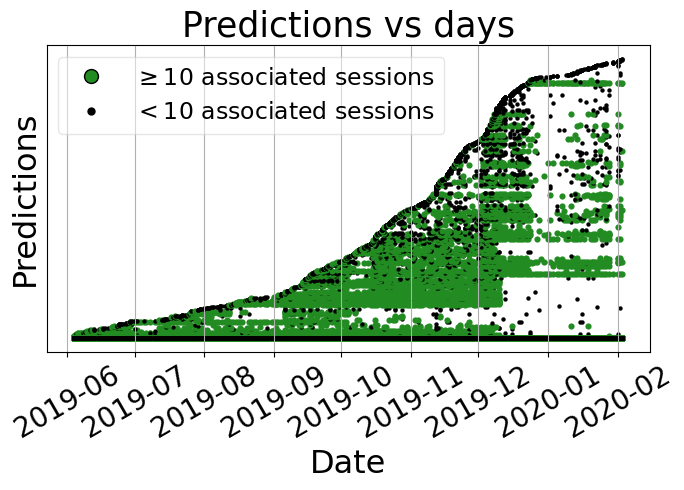

In [20]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig, axs = plt.subplots(1, figsize=(7,5))
fontsize = 20
df_count_vectorizer = df_count_vectorizer.reindex(sorted(df_count_vectorizer.columns), axis=1)
n_days = df_count_vectorizer.shape[0]
y_values = []
for it in range(first_appearance_per_prediction.shape[0]): # Rows are sorted by ascending date
    prediction = first_appearance_per_prediction.iloc[it].predictions
    is_numerous = first_appearance_per_prediction.iloc[it].is_numerous
    x_coord = df_count_vectorizer.index.values # dates
    y_coord = (it +1) * df_count_vectorizer[prediction].values # present/non present according to prediction under analysis (each gets a new row)
    c = colors[is_numerous]["color"]
    s = colors[is_numerous]["size"]
    scatters = axs.scatter(x_coord, y_coord, s = s, color = c, alpha = 1, linewidth = 0, edgecolors="k")
    if is_numerous == 1:
        y_values.append(it +1)

axs.set_title(f'Predictions vs days', fontsize = fontsize + 5)
axs.set_ylabel('Predictions', fontsize = fontsize + 3)
axs.set_xlabel('Date', fontsize = fontsize + 3)
axs.yaxis.set_ticks([])
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)  

point_major = Line2D([0], [0], label=f"$\geq{int(10)}$ associated sessions", markersize=20, markerfacecolor='forestgreen', linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
point_minor = Line2D([0], [0], label= f"$<{int(10)}$ associated sessions", markersize=10, markerfacecolor='k', linewidth = .2, markeredgecolor="k", marker='.', linestyle='')
# add manual symbols to auto legend
plt.legend(handles=[point_major, point_minor], fontsize = fontsize - 3, loc = "upper left", framealpha=0.5)
axs.grid()
plt.tight_layout()
plt.show()

### Another visualization now (Figure 11 of the paper)

Obtain number of associated sessions per fingerprint (will be the size of the point later on)

In [21]:
df_associated_sessions_per_date = joined_corpus_nan_dropped.groupby(["predictions", "date"])["sessions"].count().reset_index(name = "associated_sessions")
df_associated_sessions_per_date = df_associated_sessions_per_date.sort_values(by = "date")
df_associated_sessions_per_date.head(2)

,predictions,date,associated_sessions
8185,Execution -- Execution -- Execution -- Executi...,2019-06-04,2
1010,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04,5


Create an ID per fingerprint, given the date of birth

In [22]:
ids_predictions = first_appearance_per_prediction.sort_values(by = "date")[["predictions"]].reset_index(drop = True).reset_index().rename({"index": "Prediction_id"}, axis = 1)
ids_predictions.head(2)

,Prediction_id,predictions
0,0,Execution -- Execution -- Execution -- Executi...
1,1,Execution -- Execution -- Execution -- Executi...


In [23]:
df_associated_sessions_per_date = df_associated_sessions_per_date.merge(ids_predictions, on = "predictions")
df_associated_sessions_per_date = df_associated_sessions_per_date[df_associated_sessions_per_date.Prediction_id != df_associated_sessions_per_date.Prediction_id.max()]
df_associated_sessions_per_date.head(2)

,predictions,date,associated_sessions,Prediction_id
0,Execution -- Execution -- Execution -- Executi...,2019-06-04,2,6
1,Discovery -- Discovery -- Discovery -- Discove...,2019-06-04,5,2


#### Visualization

/tmp/ipykernel_902652/500374753.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', ticks=np.arange(1, len(list(sizes.values())), step))


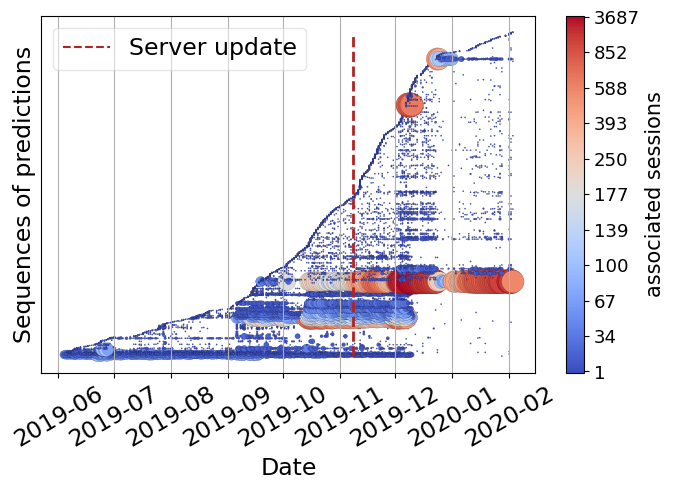

In [24]:
import numpy as np
import seaborn as sns
import matplotlib as mpl

fig, axs = plt.subplots(figsize =(7, 5))
fontsize = 15
unique_associated_sessions = df_associated_sessions_per_date.sort_values(by = "associated_sessions").drop_duplicates("associated_sessions")["associated_sessions"]
sizes = {key:value for key, value in zip(unique_associated_sessions, np.arange(1, 1*unique_associated_sessions.shape[0] + 1, 1))}
palette = sns.color_palette("coolwarm", len(sizes))
cmap = sns.color_palette("coolwarm", len(sizes), as_cmap=True)
sns.scatterplot(df_associated_sessions_per_date, palette = palette, x = "date", y = "Prediction_id", hue = "associated_sessions", size = "associated_sessions", sizes = sizes, ax = axs, legend = None, edgecolor="black")
axs.vlines(server_update_datetime, 0, df_associated_sessions_per_date.Prediction_id.max(), label = "Server update", linewidth = 2, linestyle = "dashed", color = "firebrick")
axs.set_yticks([])

server_update = Line2D([0], [0], color='firebrick', linestyle = "dashed", label= "Server update")
handles = [server_update]

# add manual symbols to auto legend
axs.legend(handles=handles, fontsize = fontsize +2, loc = "upper left", framealpha=0.5)

# creating ScalarMappable
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(list(sizes.values())))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
  
#ticks = np.arange(.5, len(list(sizes.values())) + .5)
step = round(len(list(sizes.values())) / 10)    
cbar = plt.colorbar(sm, orientation='vertical', ticks=np.arange(1, len(list(sizes.values())), step))
cbar.set_label(label='associated sessions',fontsize=fontsize)
cbar.ax.set_yticklabels(list(sizes.keys())[::step], fontsize = fontsize - 2) # Last, add real maximum
axs.grid()
axs.tick_params(axis='x', rotation=30, labelsize = fontsize+2)
axs.set_ylabel("Sequences of predictions", fontsize = fontsize + 2)
axs.set_xlabel("Date", fontsize = fontsize + 2)
plt.tight_layout()
